In [2]:
# === 1. Setup ===
from py2neo import Graph
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import lightgbm as lgb
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [3]:
# === 2. Connect to Neo4j ===
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12341234")) #Replace according to your username and password

In [4]:
# === 3. Fetch Papers and REFERS_TO relationships ===
query_papers = """
MATCH (p:Paper)
RETURN p.ID AS id, 
       p.Title AS title, 
       p.Year AS year, 
       p.CitationCount AS citations, 
       p.`Fields of Study` AS fields
LIMIT 1000
"""
papers_df = graph.run(query_papers).to_data_frame()

query_edges = """
MATCH (p1:Paper)-[:REFERS_TO]->(p2:Paper)
WHERE p1.ID <> p2.ID
RETURN p1.ID AS source, p2.ID AS target
"""
edges_df = graph.run(query_edges).to_data_frame()

In [5]:
papers_df.describe()

,year
count,997.00000
mean,1960.71013
std,12.89217
min,1832.00000
25%,1959.00000
50%,1965.00000
75%,1968.00000
max,1992.00000


In [6]:
# === 4. Create NetworkX Graph ===
G = nx.DiGraph()
G.add_nodes_from(papers_df['id'])
G.add_edges_from(edges_df[['source', 'target']].values)

In [7]:
# === 5. Create Positive and Negative Samples ===
positive_edges = list(G.edges())

def sample_negative_edges(G, num_samples, seed=42):
    random.seed(seed)
    nodes = list(G.nodes())
    negatives = set()
    while len(negatives) < num_samples:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in negatives:
            negatives.add((u, v))
    return list(negatives)

negative_edges = sample_negative_edges(G, len(positive_edges))

# Combine into dataframe
edge_data = []
for u, v in positive_edges:
    edge_data.append((u, v, 1))
for u, v in negative_edges:
    edge_data.append((u, v, 0))

edge_df = pd.DataFrame(edge_data, columns=['source', 'target', 'label'])

In [8]:
# === 6. Feature Engineering ===
def compute_graph_features(u, v):
    try:
        cn = len(list(nx.common_neighbors(G.to_undirected(), u, v)))
        aa = sum(1 / np.log(G.degree(w)) for w in nx.common_neighbors(G.to_undirected(), u, v))
        sp = nx.shortest_path_length(G.to_undirected(), source=u, target=v)
    except:
        cn, aa, sp = 0, 0, -1
    return pd.Series([cn, aa, sp])

def get_paper_info(paper_id):
    row = papers_df[papers_df['id'] == paper_id]
    if not row.empty:
        year = row.iloc[0]['year'] if pd.notnull(row.iloc[0]['year']) else 0
        citations = row.iloc[0]['citations'] if pd.notnull(row.iloc[0]['citations']) else 0
        fields = row.iloc[0]['fields'] if isinstance(row.iloc[0]['fields'], list) else []
        title = row.iloc[0]['title'] if pd.notnull(row.iloc[0]['title']) else ""
        return year, citations, fields, title
    return 0, 0, [], ""

def field_overlap(f1, f2):
    try:
        return len(set(f1).intersection(set(f2)))
    except:
        return 0

# Precompute TF-IDF for paper titles
tfidf = TfidfVectorizer(stop_words='english')
title_map = papers_df.set_index('id')['title'].fillna("").to_dict()
tfidf_matrix = tfidf.fit_transform(list(title_map.values()))
tfidf_ids = list(title_map.keys())
tfidf_index = {pid: i for i, pid in enumerate(tfidf_ids)}

def compute_text_similarity(u, v):
    if u in tfidf_index and v in tfidf_index:
        sim = cosine_similarity(tfidf_matrix[tfidf_index[u]], tfidf_matrix[tfidf_index[v]])[0][0]
        return sim
    return 0.0

In [9]:
# === 7. Optimized Feature Extraction with Caching ===

#Cache paper info
paper_info_cache = {
    row['id']: get_paper_info(row['id']) for _, row in papers_df.iterrows()
}

#Cache graph metrics (common neighbors, adamic-adar, shortest path)
G_undirected = G.to_undirected()
cn_cache = {}
aa_cache = {}
sp_cache = {}

for u, v in edge_df[['source', 'target']].values:
    try:
        cn = len(list(nx.common_neighbors(G_undirected, u, v)))
        aa = sum(1 / np.log(G_undirected.degree(w)) for w in nx.common_neighbors(G_undirected, u, v))
        sp = nx.shortest_path_length(G_undirected, source=u, target=v)
    except:
        cn, aa, sp = 0, 0, -1
    cn_cache[(u, v)] = cn
    aa_cache[(u, v)] = aa
    sp_cache[(u, v)] = sp

#Precompute text similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

def fast_text_sim(u, v):
    if u in tfidf_index and v in tfidf_index:
        return similarity_matrix[tfidf_index[u], tfidf_index[v]]
    return 0.0

#Build feature rows
features = []
for i, row in edge_df.iterrows():
    u, v = row['source'], row['target']

    if u not in paper_info_cache or v not in paper_info_cache:
        continue  # Skip missing nodes

    y1, c1, f1, _ = paper_info_cache[u]
    y2, c2, f2, _ = paper_info_cache[v]

    year_diff = abs(y1 - y2)
    citation_diff = abs(c1 - c2)
    field_sim = field_overlap(f1, f2)
    text_sim = fast_text_sim(u, v)
    cn = cn_cache.get((u, v), 0)
    aa = aa_cache.get((u, v), 0)
    sp = sp_cache.get((u, v), -1)

    features.append([year_diff, citation_diff, field_sim, text_sim, cn, aa, sp, row['label']])

features_df = pd.DataFrame(features, columns=[
    'year_diff', 'citation_diff', 'field_sim', 'text_sim',
    'common_neighbors', 'adamic_adar', 'shortest_path', 'label'
])


In [10]:
# === 8. Train Classifier using LightGBM with OpenCL ===
X = features_df.drop('label', axis=1)
y = features_df['label']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("After SMOTE:", np.bincount(y_resampled))

features_df_smote = pd.DataFrame(X_resampled, columns=X.columns)
features_df_smote['label'] = y_resampled

X_train, X_test, y_train, y_test = train_test_split(
    features_df_smote.drop('label', axis=1), 
    features_df_smote['label'], 
    test_size=0.3, 
    random_state=42
)
clf = lgb.LGBMClassifier(device='gpu', gpu_platform_id=0, gpu_device_id=0)
clf.fit(X_train, y_train)

After SMOTE: [621 621]
[LightGBM] [Info] Number of positive: 426, number of negative: 443
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 869, number of used features: 3
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Ellesmere, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2 dense feature groups (0.00 MB) transferred to GPU in 0.000965 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490219 -> initscore=-0.039130
[LightGBM] [Info] Start training from score -0.039130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

LGBMClassifier(device='gpu', gpu_device_id=0, gpu_platform_id=0)

In [11]:
# === 9. Evaluate ===
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ROC AUC: 0.9981705560357246
Precision: 0.9898477157360406

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       178
           1       0.99      1.00      0.99       195

    accuracy                           0.99       373
   macro avg       0.99      0.99      0.99       373
weighted avg       0.99      0.99      0.99       373



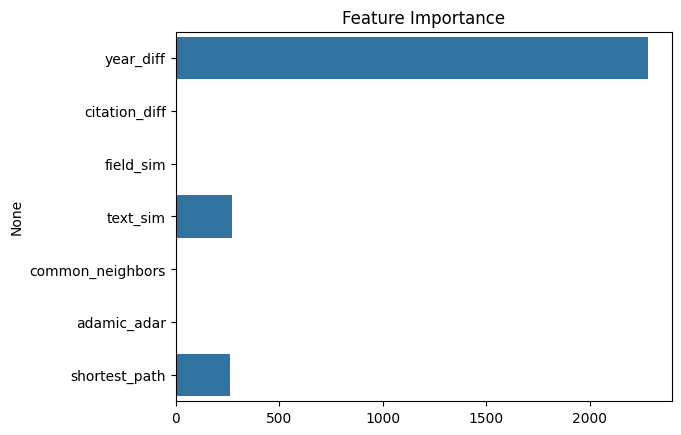

In [12]:
# === 10. Feature Importance ===
importance = clf.feature_importances_
feat_names = X.columns
sns.barplot(x=importance, y=feat_names)
plt.title("Feature Importance")
plt.show()

In [13]:
# === 11. Hyperparameter Tuning ===
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200],
    'boosting_type': ['gbdt'],
    'device': ['gpu'],
    'gpu_platform_id': [0],
    'gpu_device_id': [0]
}

# Initialize model
base_clf = lgb.LGBMClassifier()

# Perform Randomized Search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Use best estimator found
clf = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 426, number of negative: 443
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 869, number of used features: 3
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Ellesmere, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2 dense feature groups (0.00 MB) transferred to GPU in 0.000417 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490219 -> initscore=-0.039130
[LightGBM] [Info] Start training from score -0.039130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [14]:
# === 12. Evaluating best model ===
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ROC AUC: 0.9991212906943244
Precision: 0.9948979591836735

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       178
           1       0.99      1.00      1.00       195

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373



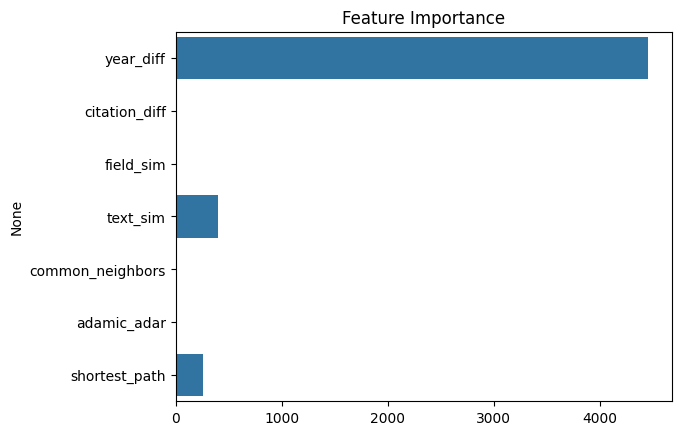

In [15]:
# === 13. Feature Importance ===
importance = clf.feature_importances_
feat_names = X.columns
sns.barplot(x=importance, y=feat_names)
plt.title("Feature Importance")
plt.show()